Library

In [1]:
import yfinance as yf
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model

Import Data

In [198]:
df = yf.download("NVDA", start = "2020-01-01", end = "2025-05-01")
print(date.today().strftime("%Y-%m-%d"))

data = df['Close'].values

print("Record:",len(data))
print(df.tail())

[*********************100%***********************]  1 of 1 completed

2025-05-03
Record: 1339
Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2025-04-24  106.430000  106.540001  103.110001  103.480003  220815000
2025-04-25  111.010002  111.919998  105.730003  106.849998  251064700
2025-04-28  108.730003  110.370003  106.019997  109.690002  207708500
2025-04-29  109.019997  110.199997  107.440002  107.669998  170444300
2025-04-30  108.919998  108.919998  104.080002  104.470001  235044600


Plot Graph

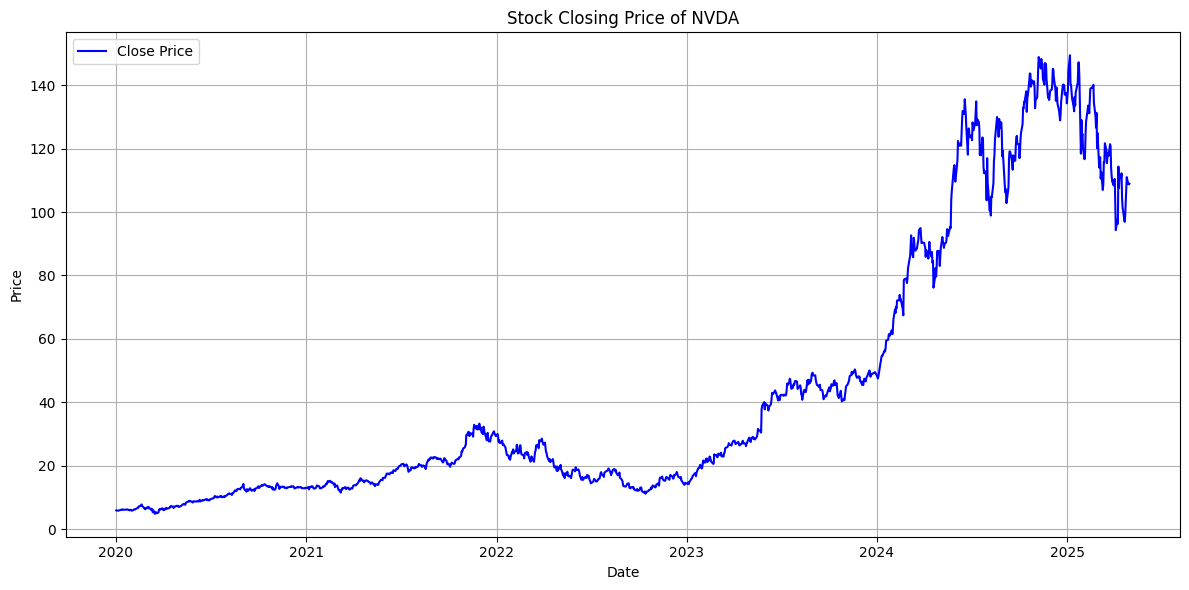

In [199]:
plt.figure(figsize = (12, 6))
plt.plot(df.index, data, label = 'Close Price', color = 'blue')
plt.title("Stock Closing Price of NVDA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Scale Data Into [0,1] and 2D

In [200]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

Split Data and Select Time Step

In [201]:
time_step = 30
train_size = int(len(scaled_data) * 0.8) 
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

X_train, y_train = [], []
X_test, y_test = [], []

for i in range(time_step, len(train_data)):
    X_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, 0])
    y_test.append(test_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(len(X_train), len(y_train), len(X_test), len(y_test))

1041 1041 238 238


Model LSTM

In [257]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mean_squared_error')

c:\Users\BOSS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Model

In [258]:
history = model.fit(X_train, y_train, epochs = 25, batch_size = 32, validation_split = 0.2)

Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0035 - val_loss: 0.0169
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1914e-04 - val_loss: 5.1261e-04
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8546e-04 - val_loss: 6.1021e-04
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6154e-04 - val_loss: 5.0275e-04
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1694e-04 - val_loss: 4.4208e-04
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5965e-04 - val_loss: 3.9917e-04
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.4373e-04 - val_loss: 4.3915e-04
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.6146e-04 - val_loss: 9.9929e-04
Epoch 9/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.7148e-04 - val_loss: 4.2775e-04
Epoch 10/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0127e-04 - val_loss: 6.0078e-04
Epoch 11/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7188e-04 - val_

Check Overfitting

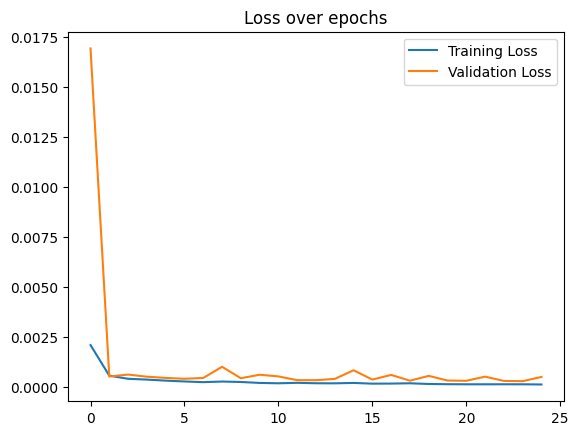

In [259]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [260]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = scaler.inverse_transform(train_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
test_pred_inv = scaler.inverse_transform(test_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

rmse_train = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
rmse_test = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train RMSE: 1.7465625976024415
Test RMSE: 7.994996185849331


Evalute Model

In [261]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [262]:
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Mean Squared Error (MSE): 63.91996401174536
Root Mean Squared Error (RMSE): 7.994996185849331
R² Score: 0.6494809601733915


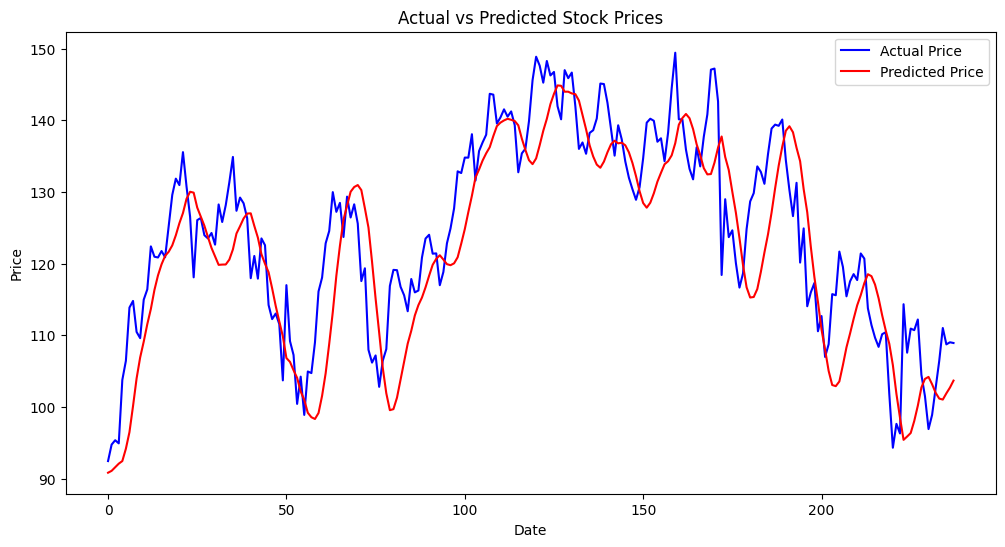

In [263]:
plt.figure(figsize = (12, 6))
plt.plot(y_test_actual, label = "Actual Price", color = 'blue')
plt.plot(predictions, label = "Predicted Price", color = 'red')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Save Model

In [264]:
model.save("NVDA_model1.h5")

In [265]:
model = load_model("NVDA_model1.h5")

Prediction

In [266]:
df = yf.download("NVDA", start = "2020-01-01", end = "2025-05-01")
data = df['Close'].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

[*********************100%***********************]  1 of 1 completed


In [268]:
time_step = 30
dataf = yf.download("NVDA", period = "31d")
dataf = dataf[:-1]
last_60 = dataf['Close'].values[-time_step:]
last_60_scaled = scaler.transform(last_60.reshape(-1, 1))
X_input = last_60_scaled.reshape(1, time_step, 1)
print(len(last_60))
print(dataf.tail())

[*********************100%***********************]  1 of 1 completed

30
Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2025-04-25  111.010002  111.919998  105.730003  106.849998  251064700
2025-04-28  108.730003  110.370003  106.019997  109.690002  207708500
2025-04-29  109.019997  110.199997  107.440002  107.669998  170444300
2025-04-30  108.919998  108.919998  104.080002  104.470001  235044600
2025-05-01  111.610001  114.940002  111.300003  113.080002  235173900


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Predicted next closing price: 105.976776


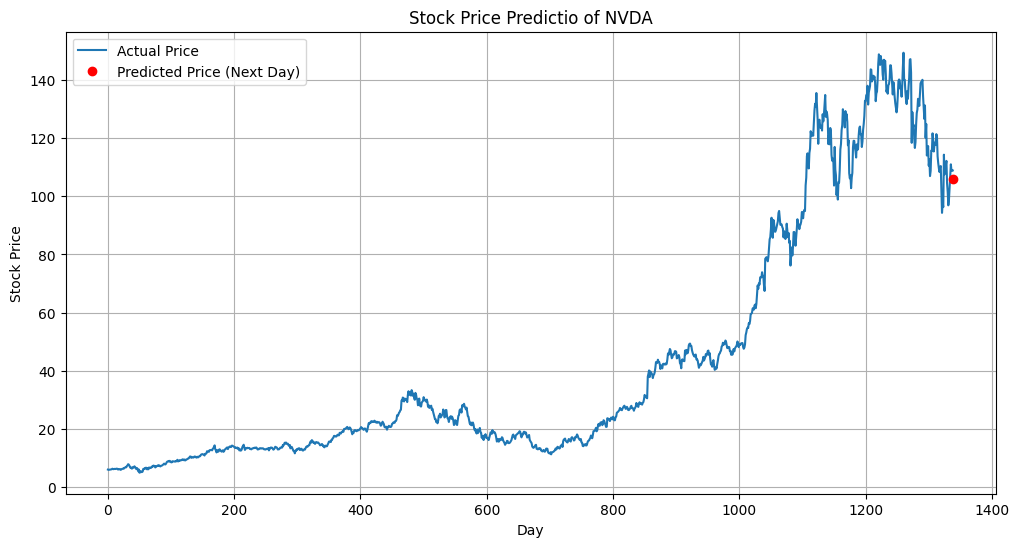

In [269]:
predicted_scaled = model.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_scaled)

print(f"Predicted next closing price:", predicted_price[0][0])

actual_prices = scaler.inverse_transform(scaled_data)

days = [i for i in range(len(actual_prices))]
days_pred = [len(actual_prices)]

plt.figure(figsize = (12, 6))
plt.plot(days, actual_prices, label = 'Actual Price')
plt.plot(days_pred, [predicted_price[0][0]], 'ro', label = 'Predicted Price (Next Day)')
plt.legend()
plt.xlabel("Day")
plt.ylabel("Stock Price")
plt.title("Stock Price Predictio of NVDA")
plt.grid(True)
plt.show()